In [1]:
import json
# EF_file = '/home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie−leftM1/ernie_EF_normE.json'
EF_file = '/home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie−leftM1/ernie_EF_normE.json'
with open(EF_file, 'r') as f:
    EF_data = json.load(f)


In [2]:
max(list(EF_data.values()))

# rearrange based on order of 

1.0116271194892918

In [3]:
#@title Helper functions

"""
This function was copied from github.com/ansteeg, the original code can be found here:
     https://github.com/ansteeg/NeuroMatchProject

     It was modified in order to use it with surface plot from BrainSpace

"""

class HCPRegions:
    """
    Translates short region names into more information.
    Attributes:
        table_path(str): path to the hcp_parcels.csv file
        table(pd.DataFrame): the loaded table as a pandas dataframe
    From the paper (doi:10.1038/nature18933):
    "Table 1 lists the 180 areas of the cortical parcellation with index number, short name,
    description, whether or not the area is new or not, the sections the area is described in,
    synonyms or ‘quasi-synonyms’ for the area, and key studies used for the area’s
    identification. A “Yes” in the ‘New?’ column signifies an area that was not previously
    described in the neuroanatomical literature as far as we are aware. For some areas, “Yes*”
    signifies subdivisions of a previously described area, homologues, or similarity to a
    previously described area but not the same. “No” means that the area was previously
    described in a very similar form to what we found here. The bold section number is the
    primary section in which the area is described. Bold studies are those that had surfacemapped
    data available for us to make direct comparisons on the same atlas mesh."
    """

    table_path = 'https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/hcp_parcels.csv'
    table = None

    def __init__(self):
        """ Inits the HCPRegions class and loads the table from file. """
        # Load table
        table_path = 'https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/hcp_parcels.csv'
        hcp_parcels = urllib2.urlopen(table_path)
        self.table = pd.read_csv(hcp_parcels, delimiter=',', encoding='utf-8')

    def get_entry(self, region_name_or_index: 'str/int'):
        """
        Retrieves the table entry for the given region.
        Args:
        region_name_or_index (str or int): the short region name, or its index
        Returns:
        (pandas entry): A pandas row containing information about this region
            columns: ParcelIndex,AreaName,AreaDescription,New,Sections,OtherNames,KeyStudies
        """

        if isinstance(region_name_or_index, str):
            regions = self.table.loc[self.table['AreaName'] == region_name_or_index]
        elif isinstance(region_name_or_index, int):
            # ParcelIndex starts at 1
            regions = self.table.loc[self.table['ParcelIndex'] == region_name_or_index + 1]
        else:
            raise ValueError(f'Region name or index must be str or int; received {type(region_name_or_index)}.')
        if regions.empty:
            raise ValueError(f'No region with name or index {region_name_or_index} found.')
        return regions.iloc[0]

    def what_is(self, region_name_or_index: 'str/int', verbose=False):
        """
        Prints information about the given region to the console.
        Args:
        region_name_or_index (str or int): the short region name, or its index
        verbose (bool, default=False): Returns more information if set to true
        """

        region = self.get_entry(region_name_or_index)
        if not verbose:
            print(f'Name of ROI {region["AreaName"]} ({region["ParcelIndex"]})\n' \
                f'Area description: {region["AreaDescription"]}\n' \
                f'Other names: {region["OtherNames"]}')
        else:
            print(f'Name of ROI {region["AreaName"]}\n' \
                f'Parcel Index: {region["ParcelIndex"]}\n' \
                f'Area description: {region["AreaDescription"]}\n' \
                f'Other names: {region["OtherNames"]}\n' \
                f'New?: {region["New"]}\n' \
                f'Sections: {region["Sections"]}\n' \
                f'Key studies: {region["KeyStudies"]}')

    def index(self, region_name_or_index: 'str/int'):
        """
        Retrieve information about the given region as a set of variables.

        Args:
        region_name_or_index (str or int): the short region name, or its index

        Returns:
        roi  (str) : Short name of ROI
        ind  (int) : Parcel index
        name (str) : Full name of ROI
        """
        region = self.get_entry(region_name_or_index)

        roi = region["AreaName"]
        ind = region["ParcelIndex"]
        name = region["AreaDescription"]

        return roi, ind, name


In [1]:
#@title Import functions
%matplotlib inline  
!pip3 install brainspace --quiet
!pip3 install panel --quiet
import ipywidgets as widgets  

# Interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets # interactive display
my_layout = widgets.Layout()

import numpy as np
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres, plot_surf
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh import mesh_cluster
import panel as pn
pn.extension('vtk')
import os # OS to handle paths
import pandas as pd # pandas for data framse
import csv
import urllib.request as urllib2

import matplotlib.pyplot as plt # For changing the color maps
from matplotlib import cm # cm=colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from hcp_regions import HCPRegions
import ipywidgets as widgets       # interactive display


In [2]:
# @title load conte 69
# First load the Glasser annotation file
file_url='https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/glasser_360_conte69.csv'
Glasser = np.loadtxt(urllib2.urlopen(file_url), dtype=int)
# and load the conte69 surfaces
Glasser

array([ 35,  52,  12, ..., 313, 313, 313])

In [3]:
surf_lh, surf_rh = load_conte69()
# Mask the 0-value ROI of the medial wall
mask = Glasser != 0
# Create an array of the ROI unique values (Nrois x 1, float)
GlasserROIs = np.asarray(np.unique(Glasser), dtype=float)
# Map ROI values to vertices indexes (Nvertices x 1)
Glasser_masked = map_to_labels(GlasserROIs, Glasser, mask=mask, fill=np.nan)

In [4]:
file_url='https://raw.githubusercontent.com/rcruces/2020_NMA_surface-plot/master/data/glasser_360_conte69.csv'
Glasser = np.loadtxt(urllib2.urlopen(file_url), dtype=np.int)

<ipython-input-4-ba9856387ec8>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Glasser = np.loadtxt(urllib2.urlopen(file_url), dtype=np.int)


In [251]:
# Create an array with random values from -1 to 1
# add a 0 entry that will match the medial wall index of the final array
rho_rand = np.concatenate((0, np.random.uniform(0,0,[360,1])), axis=None)

# Map the vector values to the vertices indices
rho_ver = map_to_labels(rho_rand, Glasser, mask=mask,fill=np.nan)

In [253]:
rho_ver = map_to_labels(ef, Glasser, mask=mask,fill=np.nan)

In [109]:
rho_ver

array([0.04471892, 0.09836338, 0.0822171 , ..., 0.1509924 , 0.1509924 ,
       0.1509924 ])

In [255]:
# I used the absolute value to facilitate the calculation 
# this is not optimal, is only use as a visualization example
# Degree = np.append(0, abs(group_fc).sum(axis=0))

# # map the nodal degree to the vertices
# DegreeVertx = map_to_labels(Degree, Glasser, mask=mask, fill=np.nan)

# Plot Surfacef
fig = plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver*0.8, size=(1000, 200), label_text={'left':['TMS Elecrtic field']},interactive=True,
                 embed_nb=True, cmap='seismic', color_bar='left', zoom=1.25, nan_color=(1, 1, 1, 1),
                 color_range=(0,1.1), screenshot=True, filename='./data/viz/less.png'
                )

In [235]:
fig.savefig('./data/viz/on.png')

AttributeError: 'Image' object has no attribute 'savefig'

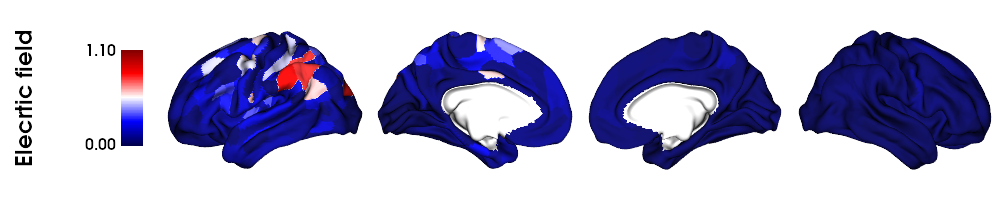

In [248]:
fig.

In [127]:
a=[0]
ef = np.array(a + (list(EF_data.values())))
# a = [0]
# a.append(ef)
ef.shape


(361,)

In [95]:
a = [0]
a = a + list(EF_data.values())
a.shape

AttributeError: 'list' object has no attribute 'shape'

### rTMS pulse gif

In [18]:
%matplotlib notebook

import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

imp = signal.unit_impulse(160, [50, 70, 90, 110, 130, 150])




x = np.linspace(0, len(imp), len(imp))
y = imp

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')
plt.title('5Hz rTMS pulse', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
# plt.yticks([])
plt.ylabel('norm Electric field (V/m)', fontsize=20)

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
#     line.axes.axis([0, 10, 0, 1])
    return line,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=1, blit=True)
ani.save('./data/viz/rTMS.gif')
plt.show()

<IPython.core.display.Javascript object>

In [279]:
import imageio

on = [50, 70, 90, 110, 130, 150]
less = []
sub = []
for i in on:
#     if i is 50:
#     less.append(i-1)
    less.append(i+1)
for i in less:
#     sub.append(i-1)
    sub.append(i+1)
    
filenames = []
for i in range(160):
    if i in on:
        filenames.append('./data/viz/on.png')
    elif i in less:
        filenames.append('./data/viz/less.png')
    elif i in sub:
        filenames.append('./data/viz/sub.png')
    else:
        filenames.append('./data/viz/off.png')
        
        
    
        

# images = []


In [284]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
kargs = { 'duration': 5 }
imageio.mimsave('./data/viz/efield.gif', images)


### # plottting TVB data

In [8]:
# plottting TVB data
lfp = np.load('./data/raw_data.npy')
labels = np.load('./data/labels_tvb.npy')

In [9]:
for i in range(160):
    time = 950+i
    lfp = np.load('./data/raw_data.npy')
    labels = np.load('./data/labels_tvb.npy')
    target = lfp[time,:]
    lfp_strength = {label: val for label, val in zip(labels, target)}
    
    # renaming to match white_matter.region_labels
    lfp_strength = { f'lh.{k[2:]}' if 'L_' in k else f'rh.{k[2:]}': v for k, v in lfp_strength.items()}
    # rearranging values and filling with zeros to match white_matter.region_labels order
    lfp_strength = np.array([lfp_strength[area] if area in lfp_strength.keys() else 0 for area in EF_data.keys()])

    a = [0]
    lfp = np.array(a + list(lfp_strength))
    rho_ver = map_to_labels(lfp, Glasser, mask=mask,fill=np.nan)
    
    

    fig = plot_hemispheres(surf_lh, surf_rh, array_name=rho_ver, size=(1000, 200), label_text={'left':['LFP']},interactive=True,
                     embed_nb=True, cmap='seismic', color_bar='left', zoom=1.25, nan_color=(1, 1, 1, 1),
                     color_range=(-50,250), screenshot=True, filename=f"./data/viz/{i}.png"
                    )

In [11]:
import imageio
filenames = []
for i in range(160):
    filenames.append(f"./data/viz/{i}.png")
    
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
# kargs = { 'duration': 5 }
imageio.mimsave('./data/viz/lfp.gif', images)

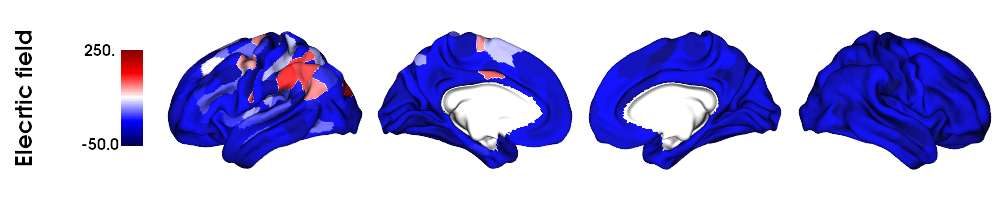

In [338]:
fig